In [1]:
import pandas as pd

In [2]:
# Function to load and extract data from a YCSB output file
def load_and_extract_ycsb_data(file_path):
    with open(file_path, 'r') as file:
        # Reading the file line by line
        lines = file.readlines()

    # Filtering out lines that match the pattern '[...], ..., ...'
    relevant_lines = [line.strip() for line in lines if line.startswith('[') and ',' in line]

    # Splitting each line into three parts and storing them in a list
    extracted_data = [line.split(', ') for line in relevant_lines]

    # Creating a DataFrame from the extracted data
    df = pd.DataFrame(extracted_data, columns=['Category', 'Metric', 'Value'])

    # Converting 'Value' to a numeric type for analysis and plotting
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

    return df

In [5]:
Mongo_WLa = load_and_extract_ycsb_data('../Data/outputMongoDB_workloada.txt')
Mongo_WLb = load_and_extract_ycsb_data('../Data/outputMongoDB_workloadb.txt')
Mongo_WLf = load_and_extract_ycsb_data('../Data/outputMongoDB_workloadf.txt')
Mysql_WLa = load_and_extract_ycsb_data('../Data/outputMySQL_workloada.txt')
Mysql_WLb = load_and_extract_ycsb_data('../Data/outputMySQL_workloadb.txt')
Mysql_WLf = load_and_extract_ycsb_data('../Data/outputMySQL_workloadf.txt')

In [12]:
def add_columns(df, database, workload):
    df['Database'] = database
    df['Workload'] = workload
    return df

In [13]:
Mongo_WLa = add_columns(Mongo_WLa, 'MongoDB', 'a')
Mongo_WLb = add_columns(Mongo_WLb, 'MongoDB', 'b')
Mongo_WLf = add_columns(Mongo_WLf, 'MongoDB', 'f')
Mysql_WLa = add_columns(Mysql_WLa, 'MySQL', 'a')
Mysql_WLb = add_columns(Mysql_WLb, 'MySQL', 'b')
Mysql_WLf = add_columns(Mysql_WLf, 'MySQL', 'f')

In [14]:
# Merging all dataframes into one
benchmark_results = pd.concat([Mongo_WLa, Mongo_WLb, Mongo_WLf, Mysql_WLa, Mysql_WLb, Mysql_WLf], ignore_index=True)

# Display the first few rows of the merged dataframe
benchmark_results.head()

,Category,Metric,Value,Database,Workload
0,[OVERALL],RunTime(ms),1864.000000,MongoDB,a
1,[OVERALL],Throughput(ops/sec),536.480687,MongoDB,a
2,[TOTAL_GCS_G1_Young_Generation],Count,2.000000,MongoDB,a
3,[TOTAL_GC_TIME_G1_Young_Generation],Time(ms),21.000000,MongoDB,a
4,[TOTAL_GC_TIME_%_G1_Young_Generation],Time(%),1.126609,MongoDB,a


In [16]:
# Save the DataFrame to a CSV file
benchmark_results.to_csv('benchmark_results.csv', index=True)

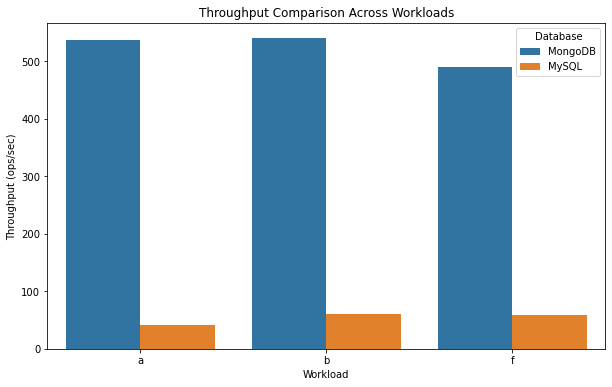

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for throughput analysis
throughput_data = benchmark_results[benchmark_results['Metric'] == 'Throughput(ops/sec)']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=throughput_data, x='Workload', y='Value', hue='Database')
plt.title('Throughput Comparison Across Workloads')
plt.xlabel('Workload')
plt.ylabel('Throughput (ops/sec)')
plt.legend(title='Database')
plt.show()

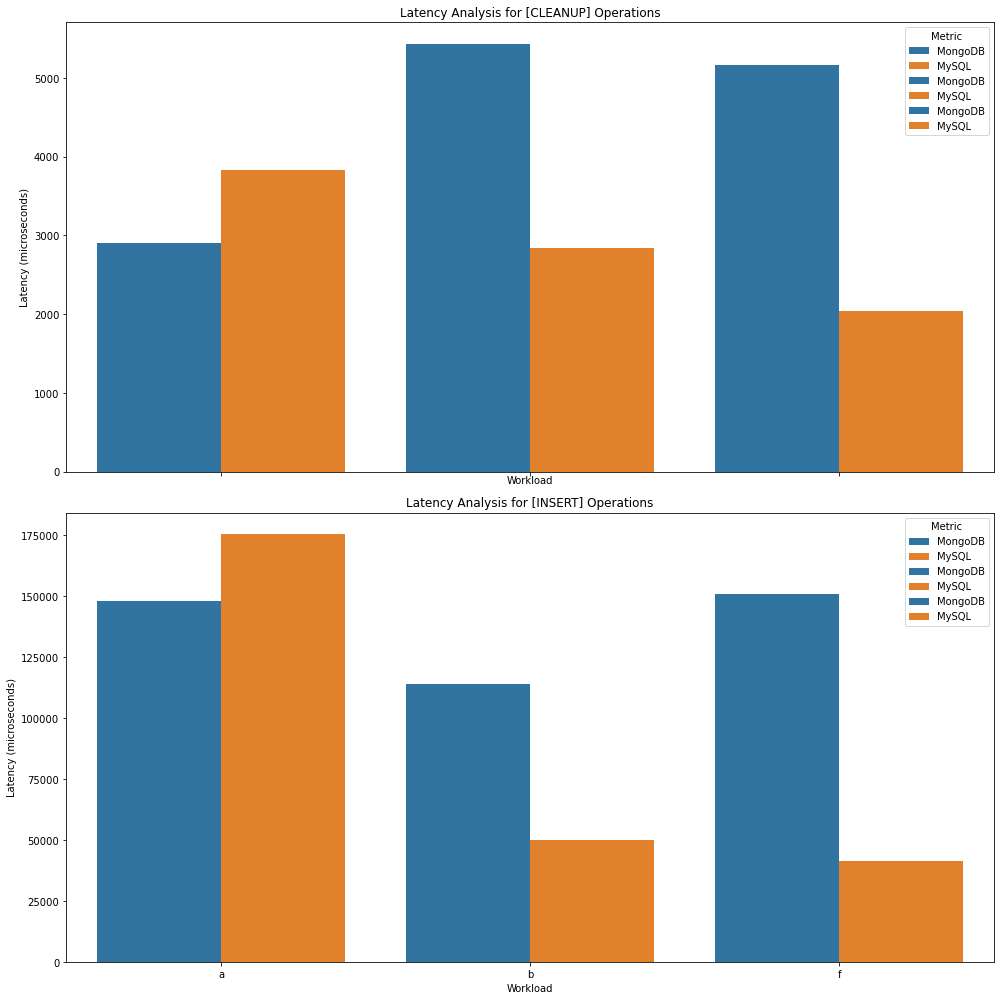

In [24]:
# Available metrics for latency
latency_metrics = ['AverageLatency(us)', 'MinLatency(us)', 'MaxLatency(us)']

available_latency_metrics = [metric for metric in latency_metrics if metric in benchmark_results['Metric'].unique()]

if available_latency_metrics:
    # Filter data for latency analysis
    latency_data = benchmark_results[benchmark_results['Metric'].isin(available_latency_metrics)]

    operation_categories = latency_data['Category'].unique()

    # Plotting
    fig, axes = plt.subplots(len(operation_categories), 1, figsize=(14, 7 * len(operation_categories)), sharex=True)
    if len(operation_categories) == 1:  
        axes = [axes]

    for i, category in enumerate(operation_categories):
        category_data = latency_data[latency_data['Category'] == category]
        for metric in available_latency_metrics:
            metric_data = category_data[category_data['Metric'] == metric]
            sns.barplot(data=metric_data, x='Workload', y='Value', hue='Database', ax=axes[i])
        axes[i].set_title(f'Latency Analysis for {category} Operations')
        axes[i].set_xlabel('Workload')
        axes[i].set_ylabel('Latency (microseconds)')
        axes[i].legend(title='Metric')

    plt.tight_layout()
    plt.show()
else:
    print("Latency metrics are not available in the dataset.")

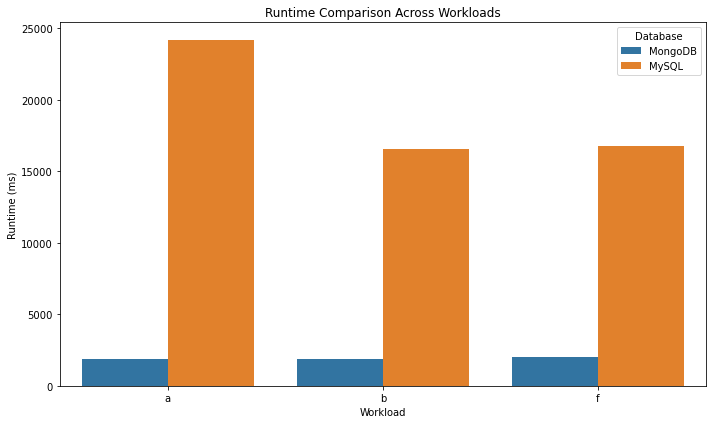

In [26]:
# Filter data for runtime comparison
runtime_data = benchmark_results[benchmark_results['Metric'] == 'RunTime(ms)']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=runtime_data, x='Workload', y='Value', hue='Database')
plt.title('Runtime Comparison Across Workloads')
plt.xlabel('Workload')
plt.ylabel('Runtime (ms)')
plt.legend(title='Database')
plt.tight_layout()  
plt.show()

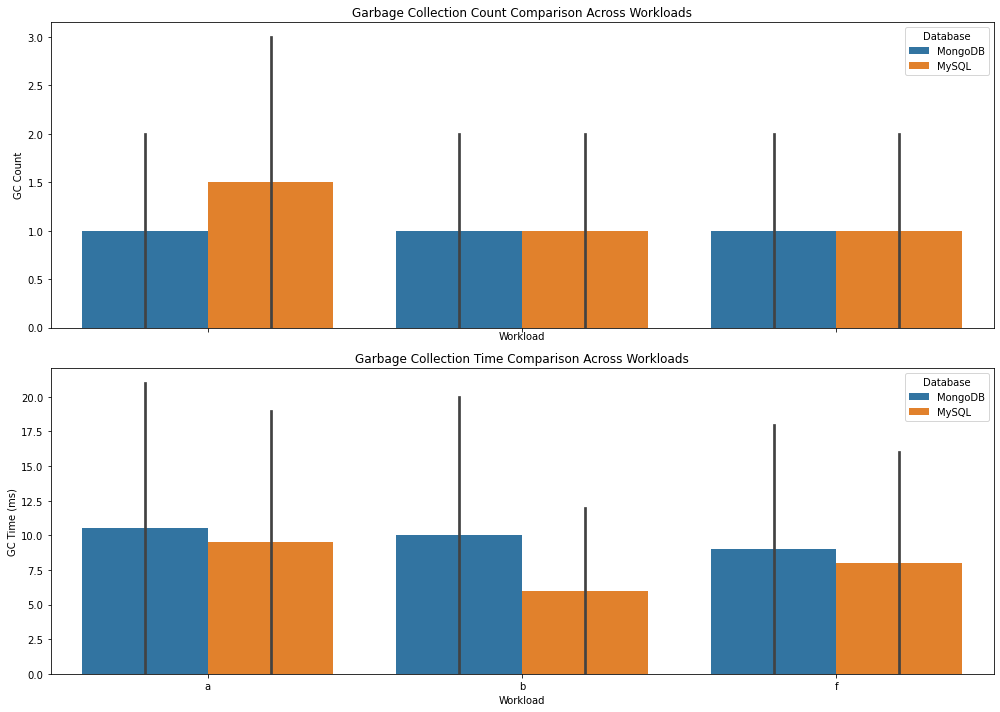

In [27]:
# Filter data for garbage collection metrics
gc_metrics_data = benchmark_results[benchmark_results['Category'].str.contains('G1')]

# Splitting the data into count and time for GC
gc_count_data = gc_metrics_data[gc_metrics_data['Metric'] == 'Count']
gc_time_data = gc_metrics_data[gc_metrics_data['Metric'] == 'Time(ms)']

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot for GC Count
sns.barplot(data=gc_count_data, x='Workload', y='Value', hue='Database', ax=axes[0])
axes[0].set_title('Garbage Collection Count Comparison Across Workloads')
axes[0].set_ylabel('GC Count')

# Plot for GC Time
sns.barplot(data=gc_time_data, x='Workload', y='Value', hue='Database', ax=axes[1])
axes[1].set_title('Garbage Collection Time Comparison Across Workloads')
axes[1].set_xlabel('Workload')
axes[1].set_ylabel('GC Time (ms)')

plt.tight_layout()
plt.show()


In [28]:
# Define the key metrics for the summary
key_metrics = ['Throughput(ops/sec)', 'AverageLatency(us)', 'RunTime(ms)']

summary_data = benchmark_results[benchmark_results['Metric'].isin(key_metrics)]

summary_table = summary_data.pivot_table(
    values='Value',
    index=['Database', 'Workload'],
    columns='Metric',
    aggfunc='mean'
).reset_index()

# Display the summary table
summary_table

Metric,Database,Workload,AverageLatency(us),RunTime(ms),Throughput(ops/sec)
0,MongoDB,a,2021.3320,1864.0,536.480687
1,MongoDB,b,3256.8065,1852.0,539.956803
2,MongoDB,f,3222.1000,2044.0,489.236791
3,MySQL,a,13636.2060,24212.0,41.301834
4,MySQL,b,9317.3380,16553.0,60.412010
5,MySQL,f,8975.9160,16777.0,59.605412
